This notebook attempts to evaluate the quality of GP waveform models as applied to waveform correlation.

For a given station and phase, we loop over all events in the validation set at that station, and extract the relevant signal. Then for each event in the training set, we:
- compute the cross-correlation peak between the *training* signal and the validation signal
- compute the cross-correlation peak between the signal predicted by the GP model *at the location of the training event*, and the validation signal.
That is, we are contrasting the *actual* training signal with the signal as reconstructed by the GP model. 

In both cases, we compute how many of the validation events have a doublet within the top 1, top 5, top 20, and top 40 training events as ranked by cross-correlation peak. This is a measure of how many validation events we'd expect to detect using waveform correlation at this station. 

Ideally, the GP predictions at each training location should match the observed signal, so the validation set correlations should be the same. This does not seem to be the case in practice. There are three failure modes:
- the relevant training event was not part of the GP training set. UNCLEAR WHY THIS HAPPENS?
- the GP signal does not match the observed signal. This can be because
 - the training signal was fit with a small envelope and explained mostly as noise
 - there are multiple overlapping phases and the relevant part of the training signal was explained partly or wholly by a different phase
 - the learned GP hyperparams have a high noise level
 Note that poor alignment of the fit templates is *not* an available explanation since we use the fit arrival times to load the training signals as well as to train the GP models
- the GP signal does match the observed signal, but some other GP prediction matches the signal even better. This can be because
 - some GP fits ground out to a single spike, which can actually be very favorable when running normalized cross-correlation.
 - some other GP fits ground out to general "templates" in the broader sense: oscillations at a particular frequency and shape, which seem to match a lot of events. So the fact that they match this event is a promising sign that it's a real detection, but doesn't necessarily mean it's in that location, because the location is so generic. 
 - some other training event just happens to correlate really well with this data. And the GP fit for that event matches the training signal really well. 

In [1]:
import numpy as np
from sigvisa import Sigvisa

from sigvisa.infer.coarse_to_fine_init import ModelSpec, EventRunSpec, TimeRangeRunSpec, do_coarse_to_fine, initialize_from, do_inference, initialize_sg
from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.treegp.gp import GPCov
from sigvisa.graph.region import Region

import cPickle as pickle

from sigvisa.utils.geog import dist_km

%matplotlib inline
import matplotlib.pylab as plt

from sigvisa.signals.common import Waveform

from sigvisa.explore.correlate_validation_events import load_arrivals
from sigvisa.explore.correlate_validation_events_align import build_sg, proposal_xc, locate_event, get_prior_nm

In [7]:
from sigvisa.infer.correlations.historical_signal_library import get_historical_signals
from sigvisa.infer.correlations.ar_correlation_model import estimate_ar, ar_advantage, iid_advantage
from sigvisa.infer.correlations.weighted_event_posterior import build_ttr_model_array, hack_ev_time_posterior_with_weight

sta = "PFO"
phase="Lg"

sg = build_sg(sta, phases=[phase,])

use_xc = False
ar_nm = None
if use_xc is False:
    wn = sg.station_waves[sta][0]
    nm = get_prior_nm(wn, 14)
    # set to None to use iid_advantage instead of ar_advantage
    ar_nm = None

def align_custom(little_signal, big_signal):
    if use_xc:
        xc = fastxc(little_signal, big_signal)
    elif ar_nm is None:
        xc = iid_advantage(big_signal, little_signal)
    else:
        xc = ar_advantage(big_signal, little_signal, ar_nm)
    return xc



In [8]:
proposals = get_historical_signals(sg)

/home/dmoore/python/sigvisa/infer/correlations/historical_signal_library.py:113: RuntimeWarning: invalid value encountered in divide
  s /= np.linalg.norm(s)


In [9]:

training_evs, training_signals = load_arrivals(sta, phase, 14, label="training")
validation_evs, validation_signals = load_arrivals(sta, phase, 14, label="validation")

top1_train = 0
top5_train = 0
top20_train = 0
top40_train = 0

top1_gp = 0
top5_gp = 0
top20_gp = 0
top40_gp = 0

top5_train_signals = []
top5_train_gpsignals = []

def find_training_proposal(ev, xs):
    for i, x in enumerate(xs):
        if np.abs(x[0,0] - ev.lon) > 1e-3: continue
        if np.abs(x[0,1] - ev.lat) > 1e-3: continue
        if np.abs(x[0,2] - ev.depth) > 1e-3: continue
        return i
    raise Exception("could not find ev %s" % ev)

for vev, vs in zip(validation_evs, validation_signals):

    evs, xcs, tsignals = locate_event(vs, training_evs, training_signals, use_xc=use_xc, ar_nm=ar_nm)
    sorted_xcs, sorted_xs, sorted_gpsignals = proposal_xc(vs, proposals, use_xc=use_xc, ar_nm=ar_nm)
    
    for i, ev in enumerate(evs[:40]):
        d = dist_km((ev.lon, ev.lat), (vev.lon, vev.lat))
        if d < 20.0:
            if i == 0:
                top1_train += 1
            if i < 5:
                top5_train += 1

                training_signal = tsignals[i]
                x = None
                gp_signal = None
                gp_rank = None
                gp_xc = None
                try:
                    gp_rank = find_training_proposal(ev, sorted_xs)
                    
                except Exception as e:
                    gp_rank = None

                if gp_rank is not None:
                    x = sorted_xs[gp_rank]
                    gp_signal = sorted_gpsignals[gp_rank]
                    gp_xc = sorted_xcs[gp_rank]
                
                n1= 1
                n2 = 2
                top_gpx = sorted_xs[n1, :]
                top_gpsignal = sorted_gpsignals[n1]
                top_gpxc = sorted_xcs[n1]
                                
                top5_train_signals.append((vev, vs, ev,training_signal, xcs[i], x, gp_signal, gp_rank, gp_xc, top_gpx, top_gpsignal, top_gpxc))

                
            if i < 20:
                top20_train += 1
            if i < 40:
                top40_train += 1
            break
    
    for i, x in enumerate(sorted_xs[:40]):
        d = dist_km((x[0, 0], x[0,1]), (vev.lon, vev.lat))
        if d < 20.0:
            if i == 0:
                top1_gp += 1
            if i < 5:
                top5_gp += 1
            if i < 20:
                top20_gp += 1
            if i < 40:
                top40_gp += 1
            break
    
    print vev

/home/dmoore/python/sigvisa/PFO_Lg_14_training_signals.pkl
/home/dmoore/python/sigvisa/PFO_Lg_14_validation_signals.pkl
evid 419957.0, loc 120.29 W 36.03 N, depth 8.9km, time 1199467154.3, mb 2.8, natural source
evid 1048308.0, loc 117.20 W 33.96 N, depth 20.5km, time 1199504452.4, mb 2.5, natural source
evid 1048376.0, loc 110.83 W 44.31 N, depth 12.4km, time 1199601015.3, mb 2.7, natural source
evid 1048401.0, loc 111.38 W 38.99 N, depth 5.4km, time 1199682280.9, mb 2.5, natural source
evid 3153428.0, loc 117.20 W 41.26 N, depth 0.0km, time 1199749207.9, mb 3.2, natural source
evid 527051.0, loc 107.73 W 40.17 N, depth 0.0km, time 1199833406.4, mb 2.5, natural source
evid 1048515.0, loc 110.97 W 44.78 N, depth 14.4km, time 1199910354.2, mb 2.9, natural source
evid 1048521.0, loc 110.96 W 44.78 N, depth 7.9km, time 1199911723.4, mb 2.9, natural source
evid 3153621.0, loc 110.90 W 44.78 N, depth 10.0km, time 1199914658.4, mb 3.7, natural source
evid 420613.0, loc 122.72 W 38.78 N, dept

In [10]:
print top1_train, top5_train, top20_train, top40_train, len(validation_evs)
print top1_gp, top5_gp, top20_gp, top40_gp, len(validation_evs)

2 11 24 31 91
2 6 18 22 91


In [11]:
print top1_train, top5_train, top20_train, top40_train, len(validation_evs)
print top1_gp, top5_gp, top20_gp, top40_gp, len(validation_evs)

21 27 31 33 35
8 19 29 31 35


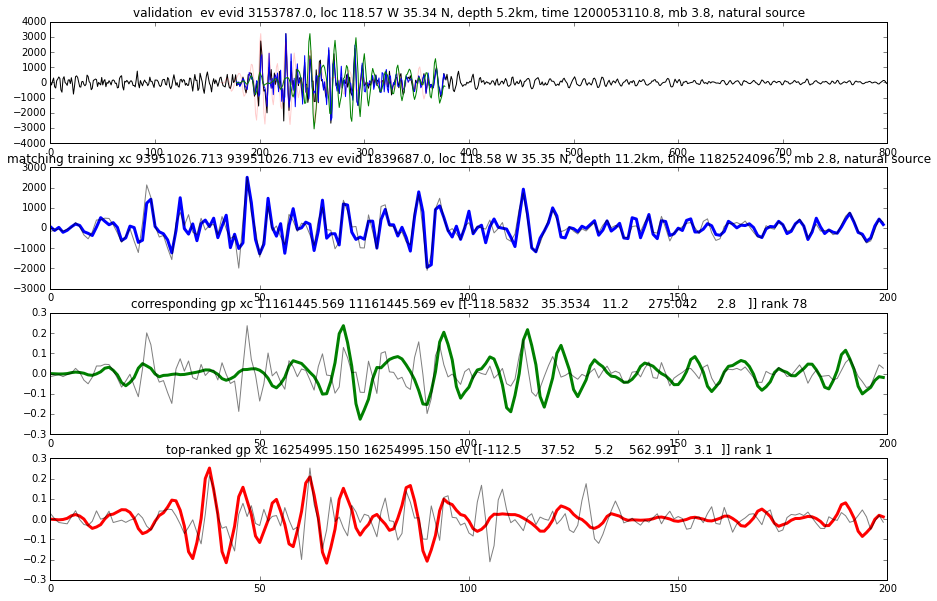

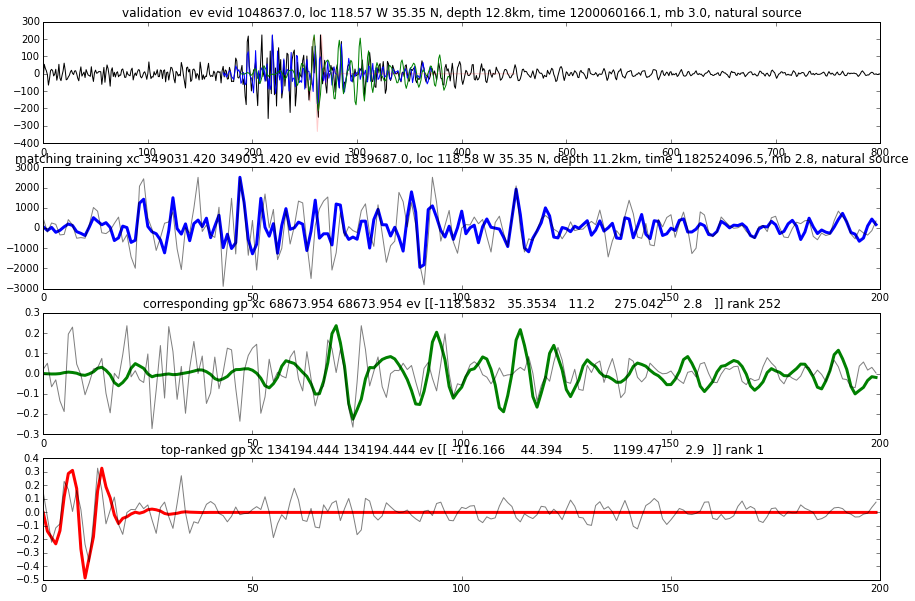

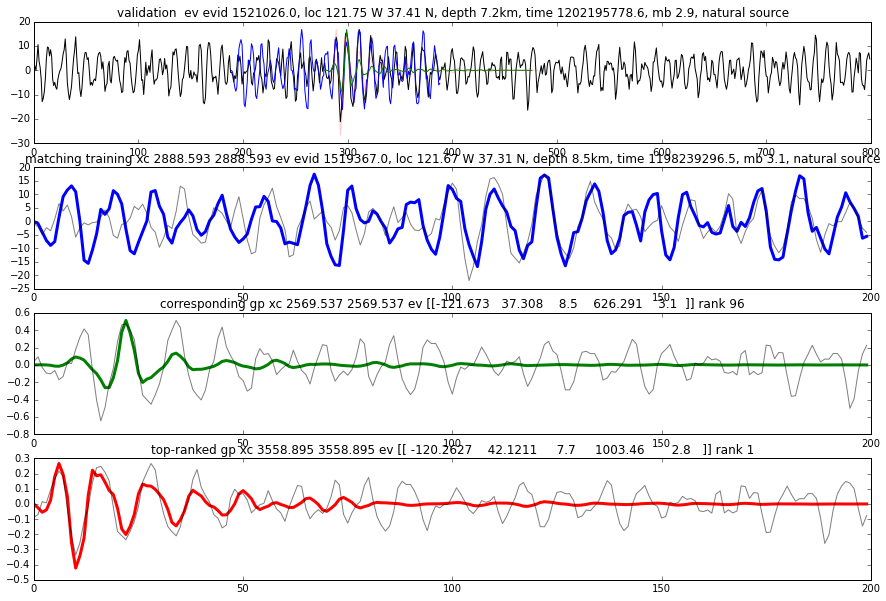

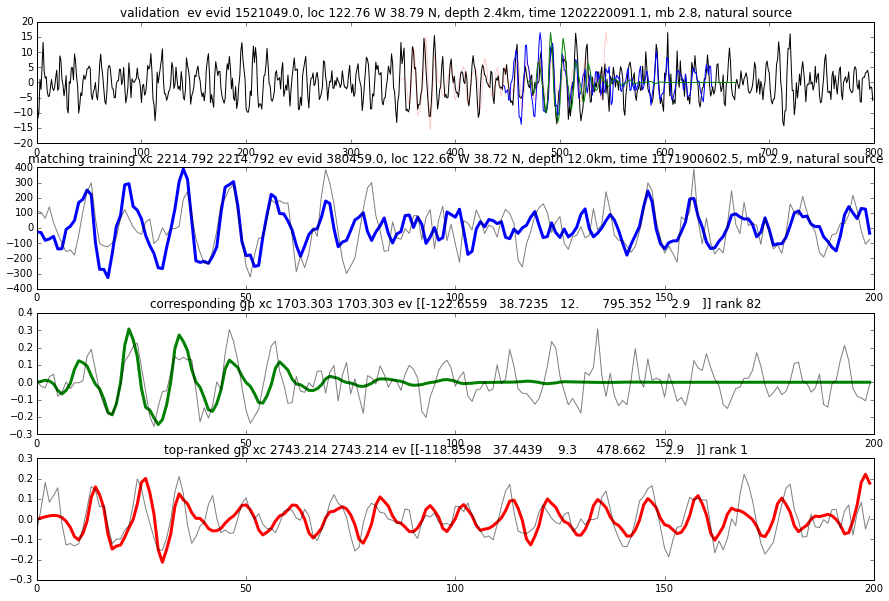

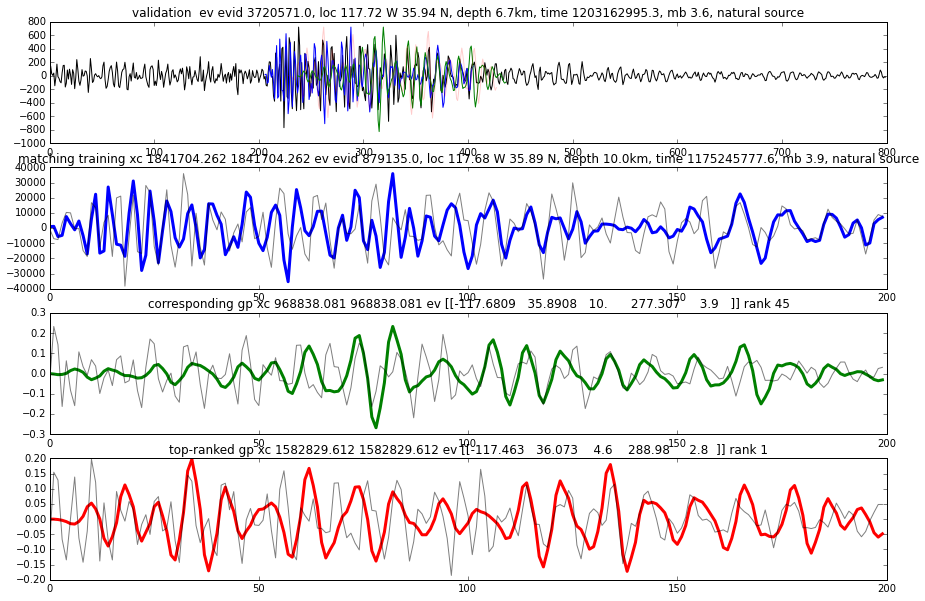

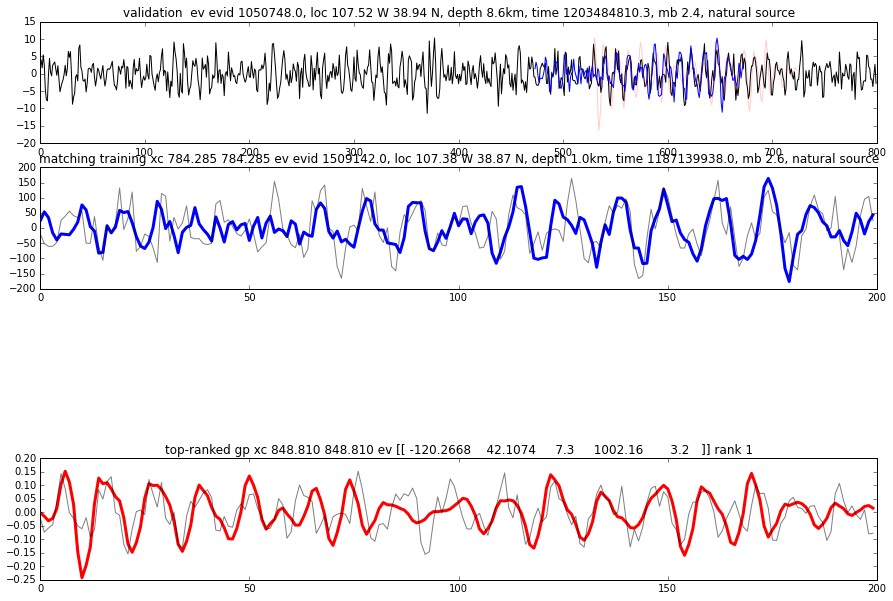

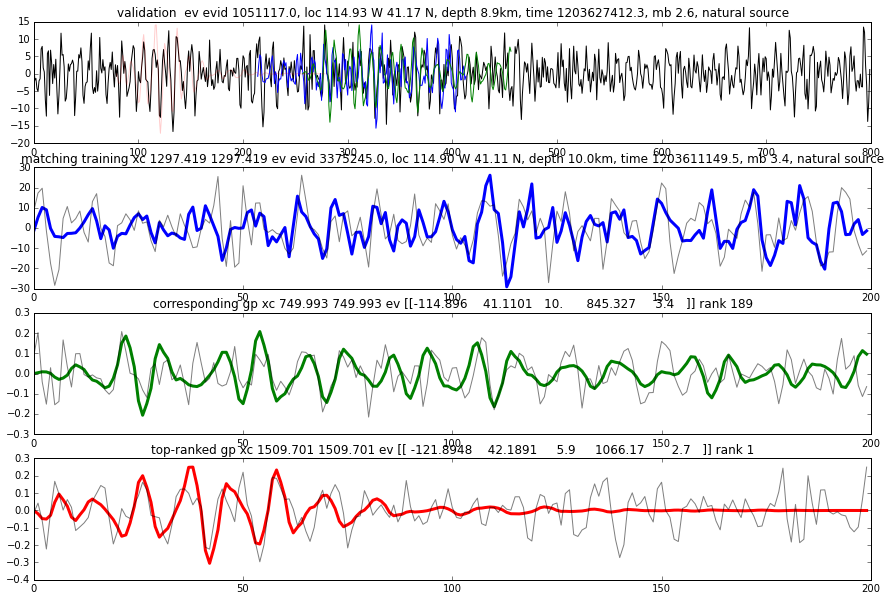

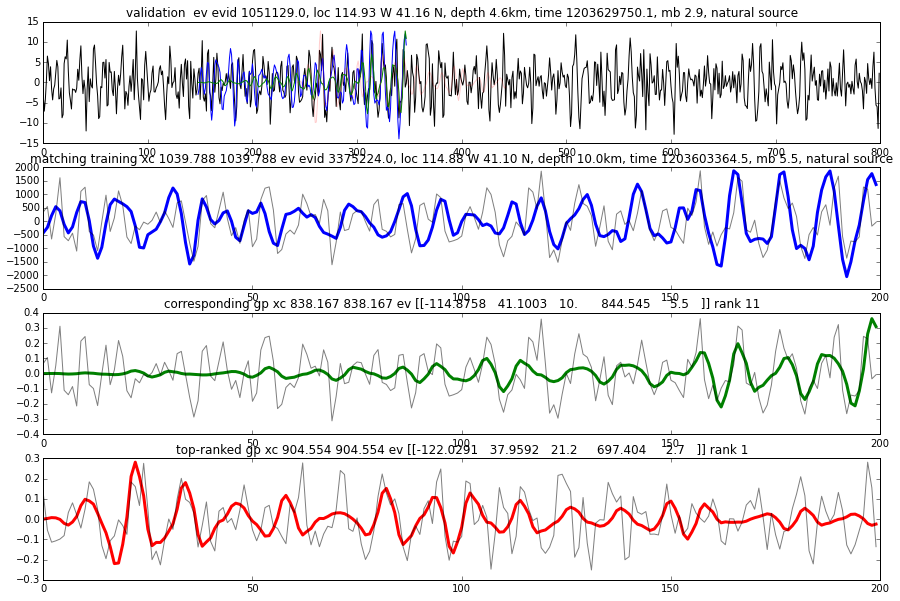

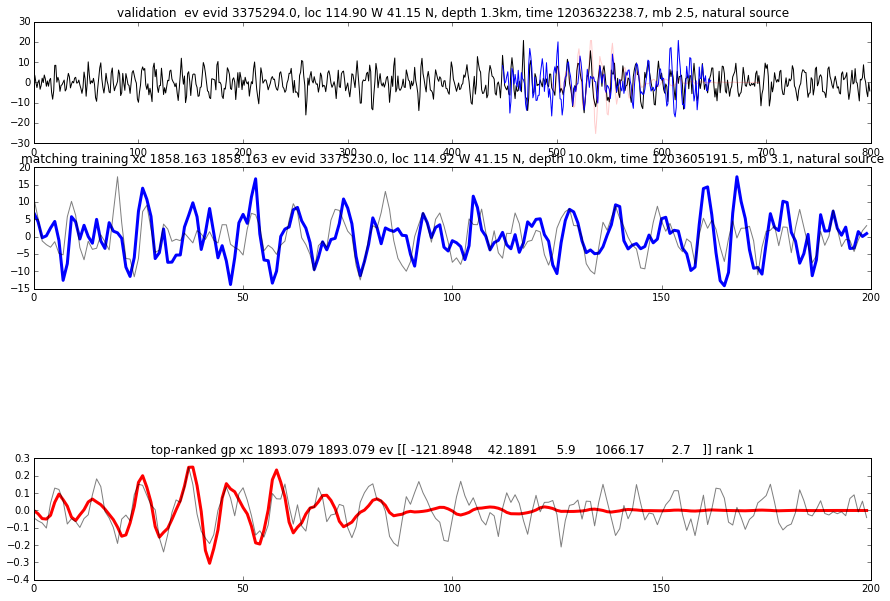

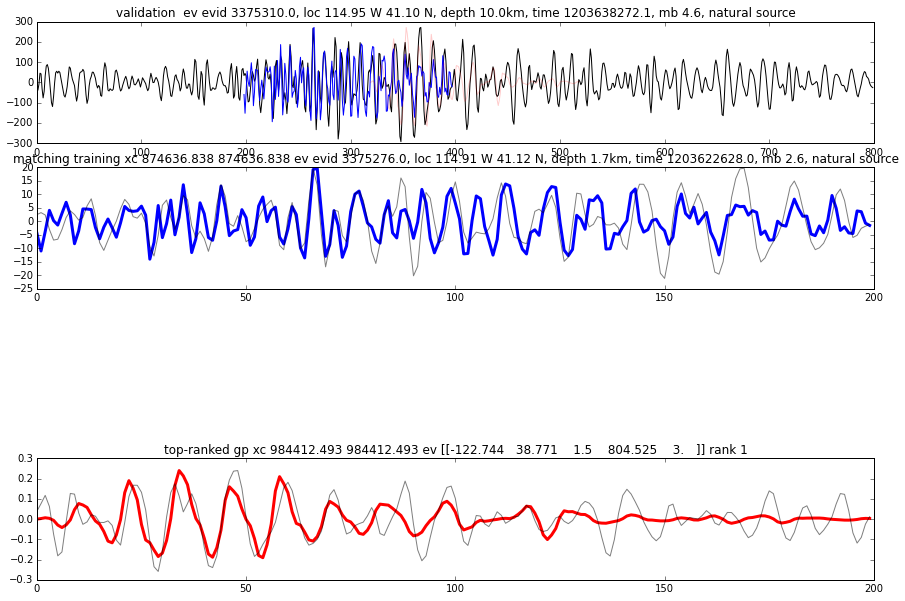

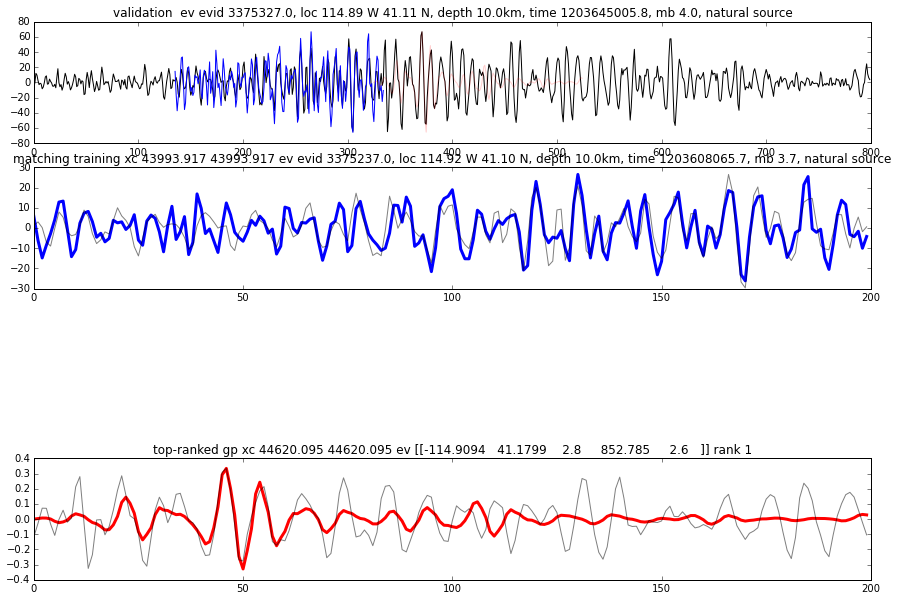

In [11]:
from sigvisa.infer.template_xc import fastxc
for (vev, vs, ev,training_signal, xc, x, gp_signal, gp_rank, gp_xc, top_gpx, top_gpsignal, top_gpxc,) in top5_train_signals:
    f = plt.figure(figsize=(15, 10))
    ax1 = f.add_subplot(411)    
    ax1.plot(vs, color="black")
    
    xcs = align_custom(training_signal, vs)
    maxidx = np.argmax(xcs)
    
    scaled_ts = training_signal * np.max(vs) / np.max(training_signal)
    ax1.plot(np.arange(maxidx, maxidx+len(training_signal)), scaled_ts, color="blue")

    
    relevant_validation = vs[maxidx:maxidx+len(training_signal)].copy()
    relevant_validation /= np.max(relevant_validation) / np.max(training_signal)
    
    ax1.set_title("validation  ev %s" % (str(vev)))

    ax = f.add_subplot(412)    
    ax.plot(training_signal, color="blue", linewidth=3)
    ax.plot(relevant_validation, color="black", alpha=0.5)
    ax.set_title("matching training xc %.3f %.3f ev %s" % (xc, np.max(xcs), str(ev)))
    if gp_signal is not None:
        gp_xcs = align_custom(gp_signal, vs)
        
        maxidx = np.argmax(gp_xcs)
        relevant_validation = vs[maxidx:maxidx+len(training_signal)].copy()
        relevant_validation /= np.max(relevant_validation) / np.max(gp_signal)
    
        scaled_gs = gp_signal * np.max(vs) / np.max(gp_signal)
        ax1.plot(np.arange(maxidx, maxidx+len(training_signal)), scaled_gs, color="green")
    
        ax = f.add_subplot(413)
        ax.plot(gp_signal, color="green", linewidth=3)
        ax.plot(relevant_validation, color="black", alpha=0.5)

        ax.set_title("corresponding gp xc %.3f %.3f ev %s rank %d" % (gp_xc, np.max(gp_xcs), str(x), gp_rank))
        
    gp_xcs = align_custom(top_gpsignal, vs)   
    maxidx = np.argmax(gp_xcs)
    relevant_validation = vs[maxidx:maxidx+len(training_signal)].copy()
    relevant_validation /= np.max(relevant_validation) / np.max(top_gpsignal)

    scaled_gs = top_gpsignal * np.max(vs) / np.max(top_gpsignal)
    ax1.plot(np.arange(maxidx, maxidx+len(training_signal)), scaled_gs, color="red", alpha=0.2)

    ax = f.add_subplot(414)
    ax.plot(top_gpsignal, color="red", linewidth=3)
    ax.plot(relevant_validation, color="black", alpha=0.5)

    ax.set_title("top-ranked gp xc %.3f %.3f ev %s rank %d" % (top_gpxc, np.max(gp_xcs), str(top_gpx), 1))

   